In [6]:
using PyPlot,JLD2,MCMCDiagnostics
rc("font",family="serif")
include("CGS.jl")
include("MCMC.jl")
include("decompose_ttvs.jl")
include("plot_ttvs.jl")

plot_ttvs (generic function with 2 methods)

### Plot of simulated years observed vs TTVs

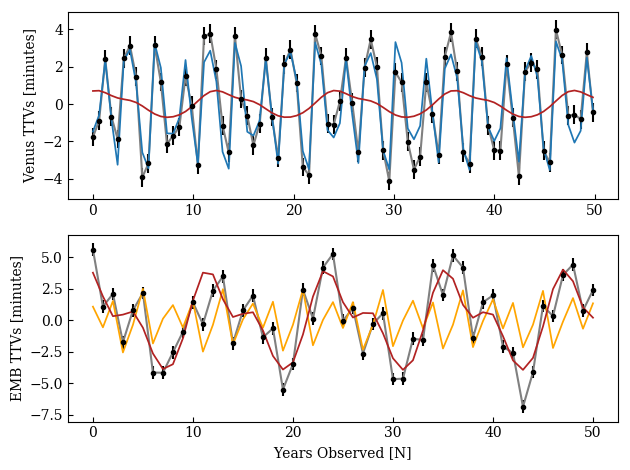

In [7]:
@load("OUTPUTS/p3_fittestparams.jld2")
@load("mcmc_testingresults.jld2")
plot_ttvs(false)

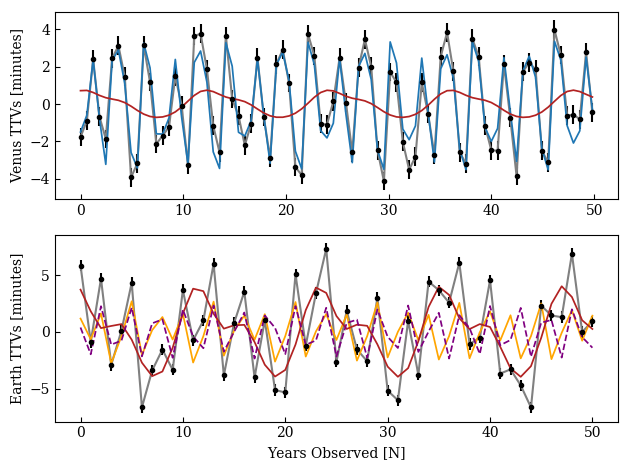

In [8]:
@load ("OUTPUTS/moon_fitmtry3params.jld2")
@load ("mcmc_mtry3results.jld2") 
plot_ttvs(true)
savefig("IMAGES/bestmoonfit.eps")

In [21]:
tmax = vec(par_mcmc[:,iburn:nsteps,16]).^2 + vec(par_mcmc[:,iburn:nsteps,17]).^2

408750-element Array{Float64,1}:
 2.4321915648287426e-6
 3.5253133347926943e-6
 2.570409361817106e-6 
 3.2141077588567012e-6
 3.138896440425795e-6 
 3.222772438455975e-6 
 2.370307208182521e-6 
 2.855564748475889e-6 
 2.834383207717035e-6 
 2.868388959285808e-6 
 2.6738642809327395e-6
 2.8491641949336146e-6
 2.4227290364979245e-6
 ⋮                    
 3.2772220064884294e-6
 2.4655095493435114e-6
 2.7175655626022763e-6
 2.7747815692023406e-6
 3.0177320815475845e-6
 2.506967809648892e-6 
 2.4573474714835043e-6
 3.645313110001913e-6 
 2.492367195433044e-6 
 2.3427374288310573e-6
 2.7178026087280072e-6
 3.195993028003299e-6 

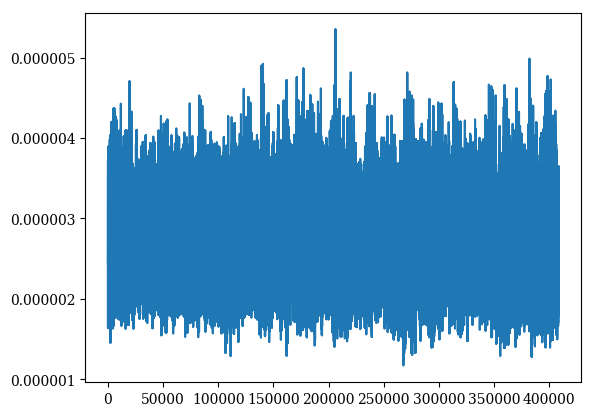

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14e1f1fd0>

In [22]:
plot(tmax)

In [12]:
include("plot_likelihood.jl")

plot_likelihood (generic function with 2 methods)

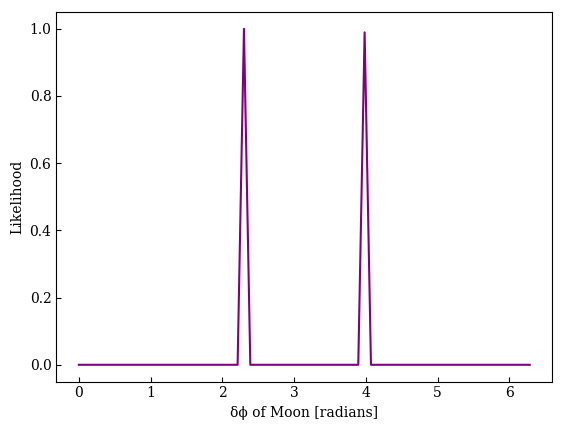

In [13]:
plot_likelihood(true)

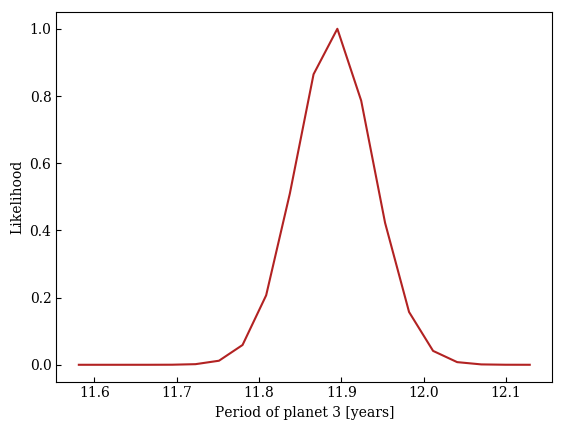

In [14]:
plot_likelihood(false)

In [ ]:
pname = ["mu_1","P_1","t01","e1 cos(om1)","e1 sin(om1)",
            "mu_2","P_2","t02","e2 cos(om2)","e2 sin(om2)",
            "mu_3","P_3","t03","e3 cos(om3)","e3 sin(om3)",
            "tmax sin(phi0)","tmax cos(phi0)","deltaphi"]

In [233]:
function vectorize_data(include_moon::Bool=false)
    names = ["mu", "P", "t0", "e cos(om)", "e sin(om)"]
    planet = ["venus", "earth", "jupiter"]
    nparam = length(param)*nplanet+1
    state_total = zeros((nsteps-iburn)*nwalkers+50,nparam-1)
    for iparam=1:nparam-1
    state_total[:,iparam] += vec(par_mcmc[:,iburn:nsteps,iparam])
    if iparam < nparam
            pname = string(planet[div(iparam-1,5)+1]," ",names[mod(iparam-1,5)+1])
    end
    #     println("index: ",iparam, " ",pname," : ",pbest_global[iparam])
    end
end
# mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
# mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
# mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
# scatter(vec(par_mcmc[1:nwalkers,1:nsteps,1]),vec(par_mcmc[1:nwalkers,1:nsteps,5]))

In [92]:
# label = ["mtry1","mtry2","mtry3","mtry4","mtry5","mtry6","mtry7"]
# sigma = [10.0, 15.0, 30.0, 45.0, 60.0, 120.0, 240.0]
nsteps = 10000
nwalkers = 50

label = "mtry1"
@load ("OUTPUTS/moon_fitmtry1params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

Step: 525 Walker: 42 Trial Log Prob: 973.494813840564 Prob: 2.568990713253006e-10 Frac: 0.34421919061047174
Step: 924 Walker: 48 Trial Log Prob: 1010.2559661821546 Prob: 0.002797002968573769 Frac: 0.32858565305857396
Step: 942 Walker: 2 Trial Log Prob: 1002.3745194190715 Prob: 0.8057715723782606 Frac: 0.3281050752359092
Number of steps: 1000 Acceptance Rate: 0.32614
Step: 1021 Walker: 18 Trial Log Prob: 986.2861542723255 Prob: 0.002733920498213466 Frac: 0.2868369351669941
Step: 1066 Walker: 15 Trial Log Prob: 1009.2869361157493 Prob: 0.01119757799363932 Frac: 0.3108728943338438
Step: 1156 Walker: 43 Trial Log Prob: 992.8788143635555 Prob: 0.09791433182338034 Frac: 0.31233157962273833
Step: 1356 Walker: 6 Trial Log Prob: 1006.8939136991604 Prob: 1.2447279937953493 Frac: 0.30417886911466546
Step: 1512 Walker: 17 Trial Log Prob: 994.569746819571 Prob: 0.022658884153292494 Frac: 0.303438025579849
Step: 1595 Walker: 27 Trial Log Prob: 1010.0917585772046 Prob: 0.2258786206436136 Frac: 0.3015

([-58.1576 -58.1576 … 1006.41 1006.41; -485.283 -485.283 … 1005.01 1005.01; … ; -1300.35 110.601 … 1005.12 1005.12; -337.598 45.3928 … 1007.7 1007.7], [2.47354e-6 2.47354e-6 … 2.53309e-6 2.53309e-6; 2.50265e-6 2.50265e-6 … 2.35469e-6 2.35469e-6; … ; 2.5474e-6 2.54053e-6 … 2.49603e-6 2.49603e-6; 2.49661e-6 2.44118e-6 … 2.40483e-6 2.40483e-6]

[224.701 224.701 … 224.701 224.701; 224.701 224.701 … 224.701 224.701; … ; 224.701 224.701 … 224.701 224.701; 224.701 224.701 … 224.701 224.701]

[2.4335e6 2.4335e6 … 2.4335e6 2.4335e6; 2.4335e6 2.4335e6 … 2.4335e6 2.4335e6; … ; 2.4335e6 2.4335e6 … 2.4335e6 2.4335e6; 2.4335e6 2.4335e6 … 2.4335e6 2.4335e6]

...

[-0.00167004 -0.00167004 … -0.0016589 -0.0016589; -0.0016599 -0.0016599 … -0.00169674 -0.00169674; … ; -0.00175706 -0.00173045 … -0.00163256 -0.00163256; -0.00159909 -0.00160989 … -0.00172841 -0.00172841]

[2.31393 2.31393 … 2.30998 2.30998; 2.31393 2.31393 … 2.3139 2.3139; … ; 2.31395 2.31395 … 2.3098 2.3098; 2.31395 2.31395 … 2.31476 2.314

In [2]:
nsteps = 10000
nwalkers = 50
label = "mtry2"
@load ("OUTPUTS/moon_fitmtry2params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

InterruptException: InterruptException:

In [5]:
nsteps = 10000
nwalkers = 50
label = "mtry3"
@load ("OUTPUTS/moon_fitmtry3params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

Step: 138 Walker: 19 Trial Log Prob: 960.10335433473 Prob: 1.7799501268653257 Frac: 0.3380404716843791
Step: 221 Walker: 40 Trial Log Prob: 919.9860791678276 Prob: 5.545294488847325e-13 Frac: 0.327445652173913
Step: 380 Walker: 21 Trial Log Prob: 968.479445993391 Prob: 4.076118408502729e-5 Frac: 0.32386273786305414
Step: 516 Walker: 14 Trial Log Prob: 967.731223731974 Prob: 0.41675690178693664 Frac: 0.32130104021114736
Step: 527 Walker: 15 Trial Log Prob: 970.068023260411 Prob: 0.02733703968187506 Frac: 0.32069162074862245
Step: 636 Walker: 44 Trial Log Prob: 970.4509740517562 Prob: 0.0001394617536705741 Frac: 0.3186135748883437
Step: 663 Walker: 43 Trial Log Prob: 954.6758009728218 Prob: 0.002464238641340629 Frac: 0.3178951814862867
Number of steps: 1000 Acceptance Rate: 0.31088
Step: 1255 Walker: 50 Trial Log Prob: 957.6307623959626 Prob: 0.3175991651506316 Frac: 0.29011764705882354
Step: 1406 Walker: 19 Trial Log Prob: 969.1025758600487 Prob: 0.12587484773905844 Frac: 0.288322068182

([536.9582995895746 536.9582995895746 … 965.5180541223333 965.5180541223333; 581.0062564545267 585.2412554050761 … 961.6507482336331 961.6507482336331; … ; 301.1920985816966 388.3370429892962 … 964.1500891091829 967.1402611752344; 156.22104983777143 354.20181050778115 … 963.7249122367361 963.7249122367361], [2.4820385666133963e-6 2.4820385666133963e-6 … 2.3463228512595104e-6 2.3463228512595104e-6; 2.3911494609844447e-6 2.390721754815025e-6 … 2.2381839740953316e-6 2.2381839740953316e-6; … ; 2.5400715349226932e-6 2.5265021189756402e-6 … 2.3956758211848595e-6 2.3585057178070333e-6; 2.4202229624146707e-6 2.460164078497137e-6 … 2.095995375139774e-6 2.095995375139774e-6]

[224.700771846633 224.700771846633 … 224.70077354314589 224.70077354314589; 224.70077436660793 224.70077431695245 … 224.700769733294 224.700769733294; … ; 224.70075209489139 224.70075567544887 … 224.70076947405596 224.70076977210272; 224.70078371929623 224.70078359215694 … 224.7007741477108 224.7007741477108]

[2.4335037687

In [ ]:
nsteps = 10000
nwalkers = 50
label = "mtry4"
@load ("OUTPUTS/moon_fitmtry4params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

In [16]:
nsteps = 10000
nwalkers = 50
label = "mtry5"
@load ("OUTPUTS/moon_fitmtry5params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

InterruptException: InterruptException:

In [ ]:
nsteps = 10000
nwalkers = 50
label = "mtry6"
@load ("OUTPUTS/moon_fitmtry6params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

In [ ]:
nsteps = 10000
nwalkers = 50
label = "mtry7"
@load ("OUTPUTS/moon_fitmtry7params.jld2")
@time lprob_mcmc,par_mcmc = MCMC(pbest_global,label,nsteps,nwalkers,nplanet,ntrans,tt0,tt,sigtt,false,true)

## MCMC Diagnostics

In [3]:
@load("mcmc_mtry1results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [11]:
nparam = 18  
samplesize = zeros(nparam)
for j=1:nwalkers
for i=1:nparam
  samplesize[i] += effective_sample_size(par_mcmc[j,:,i])
end
end
indepsamples = minimum(samplesize)
#   println("Independent Sample Size: ",indepsamples)


1600.6485560900187

In [10]:
10000 ./ samplesize

18-element Array{Float64,1}:
 6.022724150259606 
 5.666045207854207 
 5.390676487236106 
 6.192632668740094 
 5.6429277151204245
 5.142334400472557 
 6.06424135450583  
 6.069080649369204 
 6.056053931845032 
 5.701868055626515 
 6.247467604273783 
 5.7336027882757215
 5.882172685260195 
 6.189556434978975 
 5.729277402723615 
 5.261954395150772 
 6.066669009302104 
 5.204785957921757 

## MCMC steps and parameters

In [ ]:
function plot_mcmc(include_moon::Bool=false)
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i])
    ylabel(pname[i])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp1.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+5])
    ylabel(pname[i+5])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp2.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+10])
    ylabel(pname[i+10])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp3.png")
    clf()
    if include_moon
        figsize=(5,3)
        for i=1:3
        subplot(3,1,i)
        for j=1:nwalkers 
        plot(par_mcmc[j,1:nsteps,i+15])
        ylabel(pname[i+15])
        end
        # tight_layout()
        end
        name = string("IMAGES/MCMCstepsmoon.png")
    end
savefig(name)
end
# Make plot of MCMC parameters after burn-in
# figsize=(8,6)
# for i=2:nparam
#   for j=1:i-1
#     scatter(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]),vec(par_mcmc[1:nwalkers,iburn:nsteps,j]))
#     xlabel(pname[i])
#     ylabel(pname[j])
#   end
# end
# name = string("IMAGES/MCMCparams",label,".png")

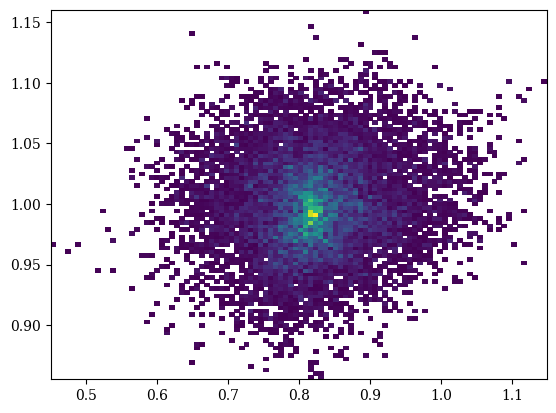

([NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [0.4503228447838222, 0.45730870171886545, 0.46429455865390873, 0.471280415588952, 0.4782662725239953, 0.48525212945903856, 0.4922379863940819, 0.49922384332912517, 0.5062097002641684, 0.5131955571992117  …  1.086035825872761, 1.093021682807804, 1.1000075397428475, 1.1069933966778907, 1.113979253612934, 1.1209651105479772, 1.1279509674830206, 1.1349368244180638, 1.1419226813531071, 1.1489085382881503], [0.8551822700113382, 0.8582357481890507, 0.8612892263667632, 0.8643427045444757, 0.8673961827221881, 0.8704496608999006, 0.8735031390776131, 0.8765566172553256, 0.8796100954330381, 0.8826635736107507  …  1.1330487841831751, 1.1361022623608876, 1.1391557405386, 1.1422092187163124, 1.145262696894025, 1.1483161750717374, 1.15136965324945, 1.1544231314271625, 1.157476609604875, 1.1605300877825875], PyObject <matplotlib.collections.QuadMesh object at 0x13c5521f0>)

In [12]:
xvalue = vec(par_mcmc[:,:,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,:,6]).*CGS.MSUN/CGS.MEARTH
function plot_params() 
# subplot(311)
hist2D(xvalue,yvalue,100,cmin=1)
end
plot_params()

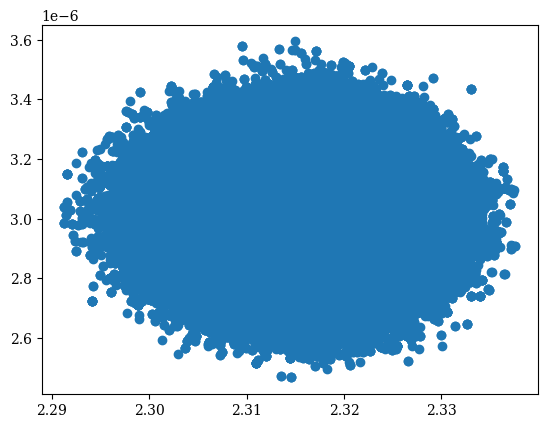

PyObject <matplotlib.collections.PathCollection object at 0x13b98cb50>

In [15]:
scatter(vec(par_mcmc[:,:,18]),vec(par_mcmc[:,:,6]))

In [ ]:
hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

In [ ]:
module CornerPlot

using DataFrames
using Gadfly
using Compose
using Viridis
using Measures

export corner


function corner(samples::Union{Array{Float64}, AbstractDataFrame};
                bins::Union{Int, Array{Int, 1}, Array{Array{Float64, 1}, 1}} = 20,
                hexbins::Union{Int, Array{Int, 1}} = 50,
                range::Union{Array{Tuple{Float64,Float64}, 1}, Void} = nothing,
                varnames::Union{Array{String, 1}, Array{Symbol, 1}, Void} = nothing,
                truthvals::Union{Array{Float64, 1}, Array{Array{Float64, 1}}, Void} = nothing,
                ylabel_orientation::Symbol = :vertical,
                plotsize::Measures.Length{:mm,Float64} = 20cm)

    # If samples are in dataframe, get array of values
    if typeof(samples) <: AbstractDataFrame

        # only take relevant columns if given
        if typeof(varnames) == Array{Symbol, 1}
            samples = Array(samples[:, varnames])
        end

    # in case a 1-d array is passed
    elseif length(size(samples)) == 1
        samples = reshape(samples, (size(samples)[1], 1))
    end

    nsamps = size(samples)[1]
    ndims = size(samples)[2]

    if ndims > nsamps
        throw(ArgumentError("samples array should not have more dimensions than samples, try reshaping/transposing"))
    end

    # now to deal with bins
    if typeof(bins) == Int
        nbins = [bins for a in 1:ndims]

        if range != nothing
            bins = [linspace(r..., nbins[i]) for (i, r) in enumerate(range)]
        else
#            bins = nothing
            bins = [[minimum(samples[:, i]), maximum(samples[:, i])] for i in 1:ndims]
        end

    elseif typeof(bins) == Array{Int, 1}
        nbins = bins

        if range != nothing
            bins = [linspace(r..., nbins[i]) for (i, r) in enumerate(range)]
        else
#            bins = nothing
            bins = [[minimum(samples[:, i]), maximum(samples[:, i])] for i in 1:ndims]
        end

    else
        nbins = [length(a) - 1 for a in bins]
    end

    # and hexbins
    if typeof(hexbins) == Int
        hexbins = [hexbins for a in 1:ndims]
    end

    # set up the plots
    set_default_plot_size(plotsize, plotsize)
    subplots = Array{Context}(ndims, ndims)

    for i in 1:ndims

        # make an array for the layers of the plots
        diagarr = []

        # make a vertical line layer if requested
        if truthvals != nothing

            # turn a single array into an array of arrays
            if typeof(truthvals) == Array{Float64, 1}
                truthvals = [[val] for val in truthvals]
            end

            vline = layer(xintercept = truthvals[i], Geom.vline,
                          Theme(default_color = colorant"red"))
            append!(diagarr, vline)
        end

        # grab only those samples which will be in the plot range
        if bins != nothing
            histsamps = samples[:, i][bins[i][1] .<= samples[:, i] .< bins[i][end]]
        else
            histsamps = samples[:, i]
        end

        # this is the 1-d histogram layer
        append!(diagarr, layer(x = histsamps, Geom.histogram(bincount = nbins[i]),
                                Theme(default_color = Viridis.viridis(0.5))))

        # for last diagonal, add axis label if given
        xlabel = nothing
        ylabel = nothing
        if varnames != nothing
            if i == 1
                ylabel = String(varnames[i])
            elseif i == ndims
                xlabel = String(varnames[i])
            end
        end

        # and plot the diagonal histogram
        subplots[i, i] = render(plot(diagarr...,
                                     Guide.xlabel(nothing),
                                     Guide.ylabel(nothing),))

        # now loop over the subplots down the column
        for j in (i + 1):ndims

            # make layer array for each offdiagonal plot
            offdiag = []

            # add the horizontal and vertical lines
            if truthvals != nothing
                append!(offdiag, vline)
                hline = layer(yintercept = truthvals[j], Geom.hline,
                              Theme(default_color = colorant"red"))
                append!(offdiag, hline)
            end

            x=histsamps
            y=samples[:, j][bins[j][1] .<= samples[:, j] .< bins[j][end]]

            # get a hexbin layer
            append!(offdiag, layer(x=x, y=y,
                                   Geom.hexbin(xbincount = hexbins[i],
                                               ybincount = hexbins[j])))

            # and add the axis labels if given
            if varnames != nothing

                # ylabels only along the side
                if i == 1
                    ylabel = String(varnames[j])
                else
                    ylabel = nothing
                end

                # xlabels only along the bottom
                if j == ndims
                    xlabel = String(varnames[i])
                else
                    xlabel = nothing
                end

            else
                xlabel = nothing
                ylabel = nothing
            end

            # and plot the layers
            subplots[j, i] = render(plot(offdiag...,
                                    Scale.color_continuous(colormap = Viridis.viridis),
                                    Guide.xlabel(xlabel),
                                    Guide.ylabel(ylabel,
                                                 orientation = ylabel_orientation),
                                    Coord.Cartesian(xmin = bins[i][1], xmax = bins[i][end],
                                                    ymin = bins[j][1], ymax = bins[j][end]),
                                    Theme(key_position = :none)))

            # make subplots above diagonal empty
            subplots[i, j] = Compose.context()
        end
    end
    gridstack(subplots)
end

end